In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 0: Install required libraries
!pip install xgboost --quiet
!pip install scikit-learn --quiet
!pip install tensorflow --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Input
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Step 1: Load the dataset
df = pd.read_csv("/content/drive/MyDrive/dec12_18features.csv")  # Upload your Kaggle dataset to Colab
print(df.shape)
df.head()


(1939207, 18)


,eventID,eventTime,sourceIPAddress,userAgent,eventName,eventSource,awsRegion,eventVersion,userIdentitytype,eventType,userIdentityaccountId,userIdentityprincipalId,userIdentityarn,userIdentityaccessKeyId,userIdentityuserName,errorCode,errorMessage,requestParametersinstanceType
0,3038ebd2-c98a-4c65-9b6e-e22506292313,2017-02,255.253,[S3Console,ListBuckets,s3.amazonaws.com,us-east-1,1.04,Root,AwsApiCall,811596193553.0,811596193553,arn:aws:iam::811596193553:root,Unknown,Unknown,NaN,NoError,NotApplicable
1,22a0d9b1-deea-4d39-827b-2af7050ed3f3,2017-02,255.253,console.amazonaws.com,GetAccountPasswordPolicy,iam.amazonaws.com,us-east-1,1.02,Root,AwsApiCall,811596193553.0,811596193553,arn:aws:iam::811596193553:root,ASIA79EXPHZ8SRL55OOE,Unknown,NoSuchEntityException,The Password Policy with domain name 811596193...,NotApplicable
2,9facf7ca-cb76-4b19-940c-3de6803f7efb,2017-02,255.253,console.amazonaws.com,GetAccountSummary,iam.amazonaws.com,us-east-1,1.02,Root,AwsApiCall,811596193553.0,811596193553,arn:aws:iam::811596193553:root,ASIA79EXPHZ8SRL55OOE,Unknown,NaN,NoError,NotApplicable
3,6596d3b4-7c98-40b1-867d-f317f1dbdc18,2017-02,255.253,console.amazonaws.com,ListAccountAliases,iam.amazonaws.com,us-east-1,1.02,Root,AwsApiCall,811596193553.0,811596193553,arn:aws:iam::811596193553:root,ASIA79EXPHZ8SRL55OOE,Unknown,NaN,NoError,NotApplicable
4,9f9d038c-e5a5-443e-83d5-4cf00941d399,2017-02,255.253,console.amazonaws.com,ListMFADevices,iam.amazonaws.com,us-east-1,1.02,Root,AwsApiCall,811596193553.0,811596193553,arn:aws:iam::811596193553:root,ASIA79EXPHZ8SRL55OOE,Unknown,NaN,NoError,NotApplicable


# Dataset Cleaning & Lable Setup

In [ ]:
# Fill missing values
df.fillna("Unknown", inplace=True)

# Drop unhelpful columns
df.drop(['eventID', 'requestID'], axis=1, errors='ignore', inplace=True)

# Assume label is in 'errorCode' (attack if not null)
df['label'] = df['errorCode'].apply(lambda x: 0 if x == "Unknown" else 1)


In [ ]:
print(df.columns.tolist())


['eventTime', 'sourceIPAddress', 'userAgent', 'eventName', 'eventSource', 'awsRegion', 'eventVersion', 'userIdentitytype', 'eventType', 'userIdentityaccountId', 'userIdentityprincipalId', 'userIdentityarn', 'userIdentityaccessKeyId', 'userIdentityuserName', 'errorCode', 'errorMessage', 'requestParametersinstanceType', 'label', 'hour', 'day', 'weekday', 'is_weekend', 'is_night']


# Feature Extraction

In [ ]:
# STEP 3: Feature Extraction

# Ensure datetime conversion
df['eventTime'] = pd.to_datetime(df['eventTime'], errors='coerce')

# Time-based features (already created earlier)
# Keeping in case re-run is needed
df['hour'] = df['eventTime'].dt.hour
df['day'] = df['eventTime'].dt.day
df['weekday'] = df['eventTime'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df['is_night'] = df['hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

# User frequency feature
user_counts = df['userIdentityuserName'].value_counts().to_dict()
df['user_event_freq'] = df['userIdentityuserName'].map(user_counts)

# IP Type feature (internal vs external)
df['ip_type'] = df['sourceIPAddress'].apply(
    lambda x: 'internal' if str(x).startswith(('10.', '192.', '172.')) else 'external'
)

# Fill missing values
df.fillna("Unknown", inplace=True)


# Encoding + Scalling

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ✅ Correct list of categorical columns
cat_cols = ['eventName', 'eventSource', 'awsRegion', 'userIdentitytype', 'eventType', 'ip_type']

# Label encode categorical columns
for col in cat_cols:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col])
    else:
        print(f"⚠️ Warning: Column '{col}' not found, skipping encoding.")

# ✅ Final feature set
features = [
    'eventName', 'eventSource', 'awsRegion', 'userIdentitytype', 'eventType',
    'hour', 'day', 'weekday', 'is_weekend', 'is_night',
    'user_event_freq', 'ip_type'
]

# Filter only columns that exist in the dataframe (safety check)
features = [f for f in features if f in df.columns]

X = df[features]
y = df['label']

# ✅ Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Outlier Detection & Removal

In [ ]:
from sklearn.ensemble import IsolationForest

# Step 5: Detect and remove outliers
iso = IsolationForest(contamination=0.01, random_state=42)
yhat = iso.fit_predict(X_scaled)

# Create a mask for inliers (i.e., non-outliers)
mask = yhat != -1

# Filter the data
X_clean = X_scaled[mask]
y_clean = y[mask]

# Optional: Print shape before/after
print("Original shape:", X_scaled.shape)
print("After removing outliers:", X_clean.shape)


Original shape: (1939207, 12)
After removing outliers: (1927265, 12)


# Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Step 6: Train-test split (after outlier removal)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

# Check shapes
print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (1541812, 12)
Test set: (385453, 12)


# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 7: Train a Random Forest model
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,         # or set to something like 20
    random_state=42,
    n_jobs=-1,
    class_weight='balanced' # handles class imbalance if any
)
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)

# Evaluation
print("📊 Random Forest Evaluation Metrics:\n")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_rf) * 100))


📊 Random Forest Evaluation Metrics:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     84264
           1       1.00      0.99      0.99    301189

    accuracy                           0.99    385453
   macro avg       0.98      0.99      0.99    385453
weighted avg       0.99      0.99      0.99    385453

Confusion Matrix:
 [[ 83894    370]
 [  2734 298455]]
Accuracy: 99.19%


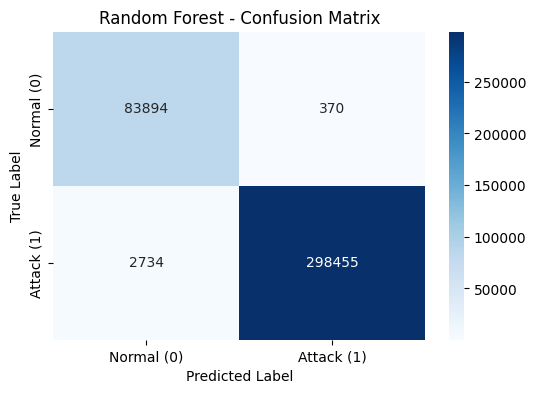

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
labels = ['Normal (0)', 'Attack (1)']

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 8: Train XGBoost model
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=200,        # increased for better learning
    max_depth=10,            # controls model complexity
    learning_rate=0.1,       # standard learning rate
    subsample=0.8,           # random row sampling
    colsample_bytree=0.8,    # random feature sampling
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

# Evaluation
print("📊 XGBoost Evaluation Metrics:\n")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_xgb) * 100))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:12:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 XGBoost Evaluation Metrics:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     84264
           1       0.99      0.99      0.99    301189

    accuracy                           0.99    385453
   macro avg       0.99      0.99      0.99    385453
weighted avg       0.99      0.99      0.99    385453

Confusion Matrix:
 [[ 82547   1717]
 [  1882 299307]]
Accuracy: 99.07%


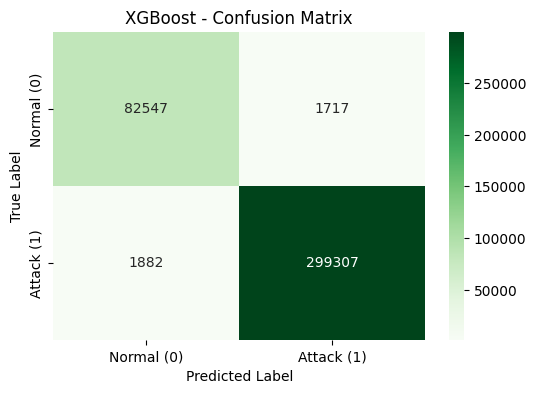

In [ ]:
# Confusion matrix heatmap for XGBoost
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal (0)', 'Attack (1)'],
            yticklabels=['Normal (0)', 'Attack (1)'])
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# DNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 9: Build and compile the model
dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = dnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

# Predict on test data
y_pred_dnn = (dnn.predict(X_test) > 0.5).astype(int)

# Evaluation
print("📊 DNN Evaluation Metrics:\n")
print(classification_report(y_test, y_pred_dnn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dnn))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_dnn) * 100))



Epoch 1/15
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.9306 - loss: 0.1647 - val_accuracy: 0.9639 - val_loss: 0.0850
Epoch 2/15
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - accuracy: 0.9617 - loss: 0.0896 - val_accuracy: 0.9666 - val_loss: 0.0759
Epoch 3/15
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.9659 - loss: 0.0812 - val_accuracy: 0.9762 - val_loss: 0.0603
Epoch 4/15
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.9728 - loss: 0.0684 - val_accuracy: 0.9794 - val_loss: 0.0547
Epoch 5/15
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9758 - loss: 0.0626 - val_accuracy: 0.9806 - val_loss: 0.0509
Epoch 6/15
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.9771 - loss: 0.0589 - val_accuracy: 0.9821 - val_loss: 0.0474
Epoch 7/15
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.9784 - loss: 0.0559 - val_accuracy: 0.9813 - val_loss: 0.0478
Epoch 8/15
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.9785 -

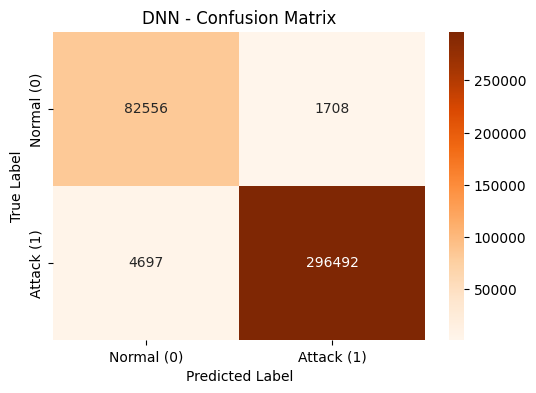

In [ ]:
# Confusion matrix for DNN
cm = confusion_matrix(y_test, y_pred_dnn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Normal (0)', 'Attack (1)'],
            yticklabels=['Normal (0)', 'Attack (1)'])
plt.title("DNN - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Autoencoder + DNN (Hybrid)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define input shape
input_dim = X_train.shape[1]

# Step 10A: Build the Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

# Compile and train AE
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Fit the autoencoder on X_train
autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=512,
                shuffle=True,
                validation_split=0.2,
                verbose=1)


Epoch 1/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.0592 - val_loss: 3.1746e-04
Epoch 2/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 6.4339e-04 - val_loss: 4.1797e-04
Epoch 3/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 3.7896e-04 - val_loss: 1.7708e-04
Epoch 4/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 2.1913e-04 - val_loss: 5.2236e-04
Epoch 5/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 3.7458e-04 - val_loss: 9.4265e-05
Epoch 6/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 2.0184e-04 - val_loss: 2.6967e-04
Epoch 7/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 1.7891e-04 - val_loss: 2.3077e-04
Epoch 8/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 2.2449e-04 - val_loss: 1.7362e-04
Epoch 9/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 2.6433e-04 - val_loss: 6.1301e-05
Epoch 10/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 1.1389e-04 - val_loss: 6.7129e-05


In [ ]:
# Extract encoder part only
encoder = Model(inputs=input_layer, outputs=encoded)

# Compress the train and test sets
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)


48182/48182 ━━━━━━━━━━━━━━━━━━━━ 126s 3ms/step
12046/12046 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step


In [ ]:
# Build the DNN classifier on top of AE-compressed data
clf = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_encoded.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the classifier
clf.fit(X_train_encoded, y_train,
        epochs=10,
        batch_size=512,
        validation_split=0.2,
        verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.9201 - loss: 0.1929 - val_accuracy: 0.9579 - val_loss: 0.0996
Epoch 2/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9557 - loss: 0.1051 - val_accuracy: 0.9642 - val_loss: 0.0872
Epoch 3/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9600 - loss: 0.0945 - val_accuracy: 0.9652 - val_loss: 0.0838
Epoch 4/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9622 - loss: 0.0891 - val_accuracy: 0.9668 - val_loss: 0.0787
Epoch 5/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9643 - loss: 0.0853 - val_accuracy: 0.9691 - val_loss: 0.0749
Epoch 6/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9666 - loss: 0.0814 - val_accuracy: 0.9700 - val_loss: 0.0722
Epoch 7/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9679 - loss: 0.0789 - val_accuracy: 0.9734 - val_loss: 0.0678
Epoch 8/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9690 - loss: 0

In [ ]:
# Predict on test data
y_pred_ae = (clf.predict(X_test_encoded) > 0.5).astype(int)

# Evaluation
print("📊 AE + DNN Evaluation Metrics:\n")
print(classification_report(y_test, y_pred_ae))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ae))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_ae) * 100))


12046/12046 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
📊 AE + DNN Evaluation Metrics:

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     84264
           1       0.99      0.98      0.98    301189

    accuracy                           0.97    385453
   macro avg       0.96      0.97      0.96    385453
weighted avg       0.97      0.97      0.97    385453

Confusion Matrix:
 [[ 80638   3626]
 [  6521 294668]]
Accuracy: 97.37%


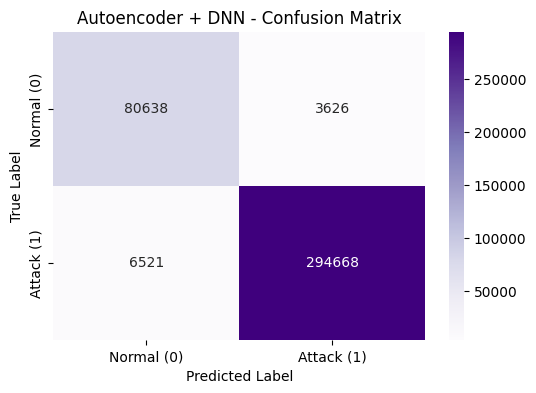

In [ ]:
cm = confusion_matrix(y_test, y_pred_ae)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Normal (0)', 'Attack (1)'],
            yticklabels=['Normal (0)', 'Attack (1)'])
plt.title("Autoencoder + DNN - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# LightGBM Classifier

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 11A: Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Step 11B: Set parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'learning_rate': 0.05,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

# Step 11C: Train LightGBM model
lgbm_model = lgb.train(params, train_data, num_boost_round=200)

# Step 11D: Predict
y_pred_lgb = (lgbm_model.predict(X_test) > 0.5).astype(int)

# Step 11E: Evaluation
print("📊 LightGBM Evaluation Metrics:\n")
print(classification_report(y_test, y_pred_lgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgb))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_lgb) * 100))


📊 LightGBM Evaluation Metrics:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     84264
           1       0.99      0.99      0.99    301189

    accuracy                           0.99    385453
   macro avg       0.99      0.99      0.99    385453
weighted avg       0.99      0.99      0.99    385453

Confusion Matrix:
 [[ 82554   1710]
 [  2006 299183]]
Accuracy: 99.04%


# Comparission of models

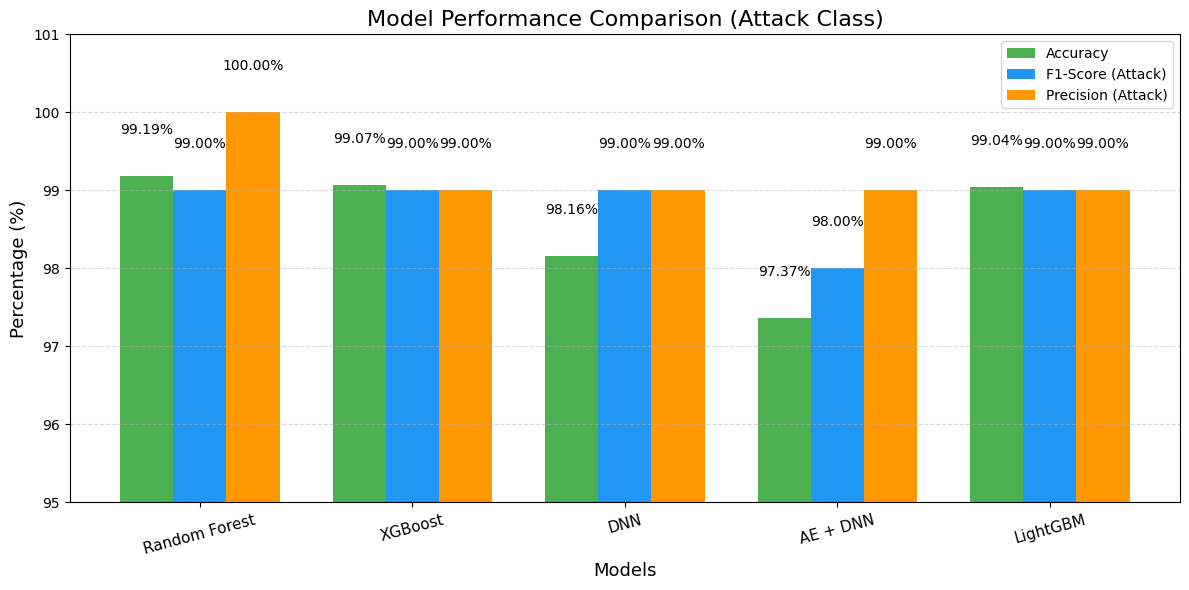

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Random Forest', 'XGBoost', 'DNN', 'AE + DNN', 'LightGBM']

# Metrics for Class 1 (Attack)
accuracy = [99.19, 99.07, 98.16, 97.37, 99.04]
f1_score = [0.99, 0.99, 0.99, 0.98, 0.99]
precision = [1.00, 0.99, 0.99, 0.99, 0.99]

# Convert f1/precision to percentages
f1_score = [x * 100 for x in f1_score]
precision = [x * 100 for x in precision]

# Bar chart parameters
x = np.arange(len(models))
width = 0.25

# Create plot
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width, accuracy, width, label='Accuracy', color='#4CAF50')
bars2 = plt.bar(x, f1_score, width, label='F1-Score (Attack)', color='#2196F3')
bars3 = plt.bar(x + width, precision, width, label='Precision (Attack)', color='#FF9800')

# Annotate bars
def annotate(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

annotate(bars1)
annotate(bars2)
annotate(bars3)

# Styling
plt.title('Model Performance Comparison (Attack Class)', fontsize=16)
plt.xlabel('Models', fontsize=13)
plt.ylabel('Percentage (%)', fontsize=13)
plt.xticks(x, models, rotation=15, fontsize=11)
plt.ylim(95, 101)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
